# Deep Skuf Learning team ML Notebook

## Installing all necessary libraries

In [1]:
!pip install catboost
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install matplotlib
!pip install seaborn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

## Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Loading training data and preprocessing

In [3]:
df = pd.read_csv('train.csv')
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.drop_duplicates()
df = df.dropna()
df

full_sq  floor  build_year  num_room  kitch_sq  state  product_type  \
0           43   24.0      2014.0       1.0      10.0    1.0             1   
1           66    3.0      1979.0       3.0      10.0    3.0             0   
2           55    5.0      1979.0       2.0       6.0    2.0             0   
3           45    7.0      1970.0       2.0       6.0    2.0             0   
4           43    4.0      1968.0       2.0       6.0    2.0             0   
...        ...    ...         ...       ...       ...    ...           ...   
21324       56   19.0      1979.0       2.0       1.0    1.0             1   
21325       42    5.0      1977.0       1.0       8.0    3.0             0   
21326       32    3.0      1979.0       2.0       6.0    2.0             0   
21327       43    4.0      1969.0       2.0       5.0    2.0             0   
21328       32    1.0      1979.0       2.0       6.0    2.0             0   

       raion_popul  indust_part  sport_objects_raion  ...  \
0         8.294300     0.007122                    0  ...   
1        11.314231     0.232205                    4  ...   
2        11.718817     0.000170                    5  ...   
3        11.331032     0.428826                    4  ...   
4        11.538769     0.136330                    6  ...   
...            ...          ...                  ...  ...   
21324    11.655744     0.049637                    6  ...   
21325    11.718817     0.000170                    5  ...   
21326    11.719940     0.000000                    4  ...   
21327    11.331032     0.428826                    4  ...   
21328    11.793198     0.130618                   12  ...   

       cafe_count_1000_price_high  cafe_sum_1500_min_price_avg  \
0                               0                     6.907755   
1                               0                     6.626122   
2                               0                     6.368753   
3                               0                     6.753601   
4                               0                     6.636603   
...                           ...                          ...   
21324                           0                     6.492240   
21325                           0                     6.502295   
21326                           0                     6.572814   
21327                           0                     6.586172   
21328                           0                     6.536692   

       green_part_2000  cafe_sum_2000_min_price_avg  mosque_count_3000  \
0             3.710396                     6.725430                  0   
1             2.764431                     6.479615                  1   
2             3.511844                     6.192138                  0   
3             1.814825                     6.551080                  0   
4             2.257588                     6.646507                  1   
...                ...                          ...                ...   
21324         2.711378                     6.816188                  0   
21325         3.802208                     6.291569                  0   
21326         3.062456                     6.583520                  1   
21327         2.408745                     6.563982                  0   
21328         1.726332                     6.543538                  0   

       prom_part_5000  cafe_sum_5000_min_price_avg  mosque_count_5000  year  \
0            1.803359                     6.616560                  0  2014   
1            2.631169                     6.469948                  1  2013   
2            1.363537                     6.462171                  0  2012   
3            2.732418                     6.458229                  0  2014   
4            2.020222                     6.634778                  2  2014   
...               ...                          ...                ...   ...   
21324        3.297317                     6.536155                  0  2014   
21325        1.442202  

## Creating new features

In [4]:
df['avg_room_sq'] = (df['full_sq'] - df['kitch_sq']) / df['num_room']
df['avg_sport_km'] = df[['fitness_km', 'stadium_km', 'basketball_km']].mean(axis=1)
df['avg_culture_km'] = df[['theater_km', 'exhibition_km']].mean(axis=1)
df['build_material_idx'] = df[['build_count_block', 'build_count_brick', 'build_count_monolith']].mean(axis=1)
df['mosque_accessibility'] = (df[['mosque_count_3000', 'mosque_count_5000']].sum(axis=1) > 0).astype(int)
df['education_avg'] = df[['school_km', 'additional_education_km']].mean(axis=1)
df['transport_accessibility'] = (df['mkad_km'] + df['ttk_km']) / df['metro_min_avto']
df['cafe_avg'] = df[['cafe_sum_1000_min_price_avg', 'cafe_sum_1500_min_price_avg', 'cafe_sum_2000_min_price_avg', 'cafe_sum_5000_min_price_avg']].mean(axis=1)
df['ecology_idx'] = df['water_treatment_km'] / df['green_zone_km']
df['status_raion_avg'] = df[['sport_objects_raion', 'shopping_centers_raion', 'radiation_raion']].mean(axis=1)
df['green_part_weighted'] = df['green_part_2000'] * 0.2 + df['green_part_1000'] * 0.8

In [6]:
# Average distance across all labels
km_columns = [col for col in df.columns if col.endswith('km')]
df['average_km'] = df[km_columns].mean(axis=1)

# Categorizing distances
bins = [-np.inf, 1.0, 1.3, 1.4, np.inf]
labels = ['Very close', 'Close', 'Middle', 'Far']
df['km_category'] = pd.cut(df['average_km'], bins=bins, labels=labels)
df['km_category'] = df['km_category'].map({'Very close': 4, 'Close': 3, 'Middle': 2, 'Far': 1}).astype(str)


In [7]:
# Ensuring all categorical features are strings in the test data
categorical_columns = ['state', 'product_type', 'radiation_raion', 'mosque_accessibility', 'km_category']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype(str) 

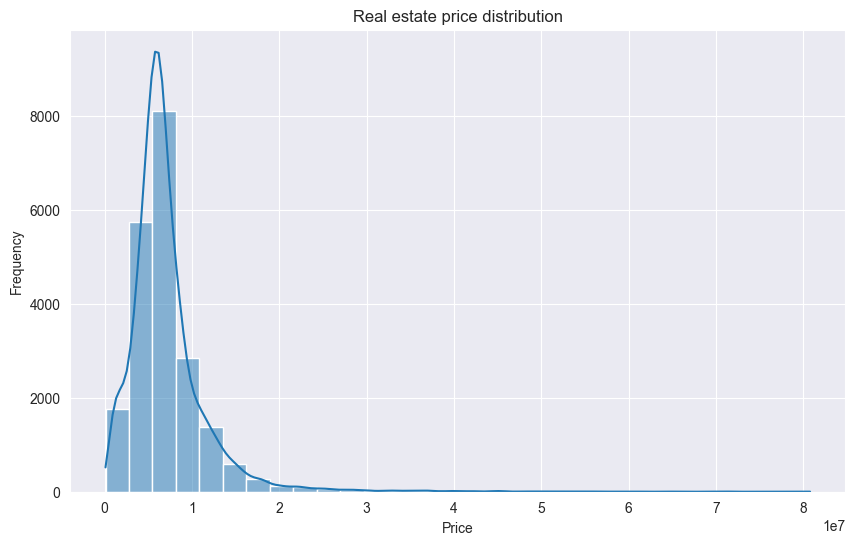

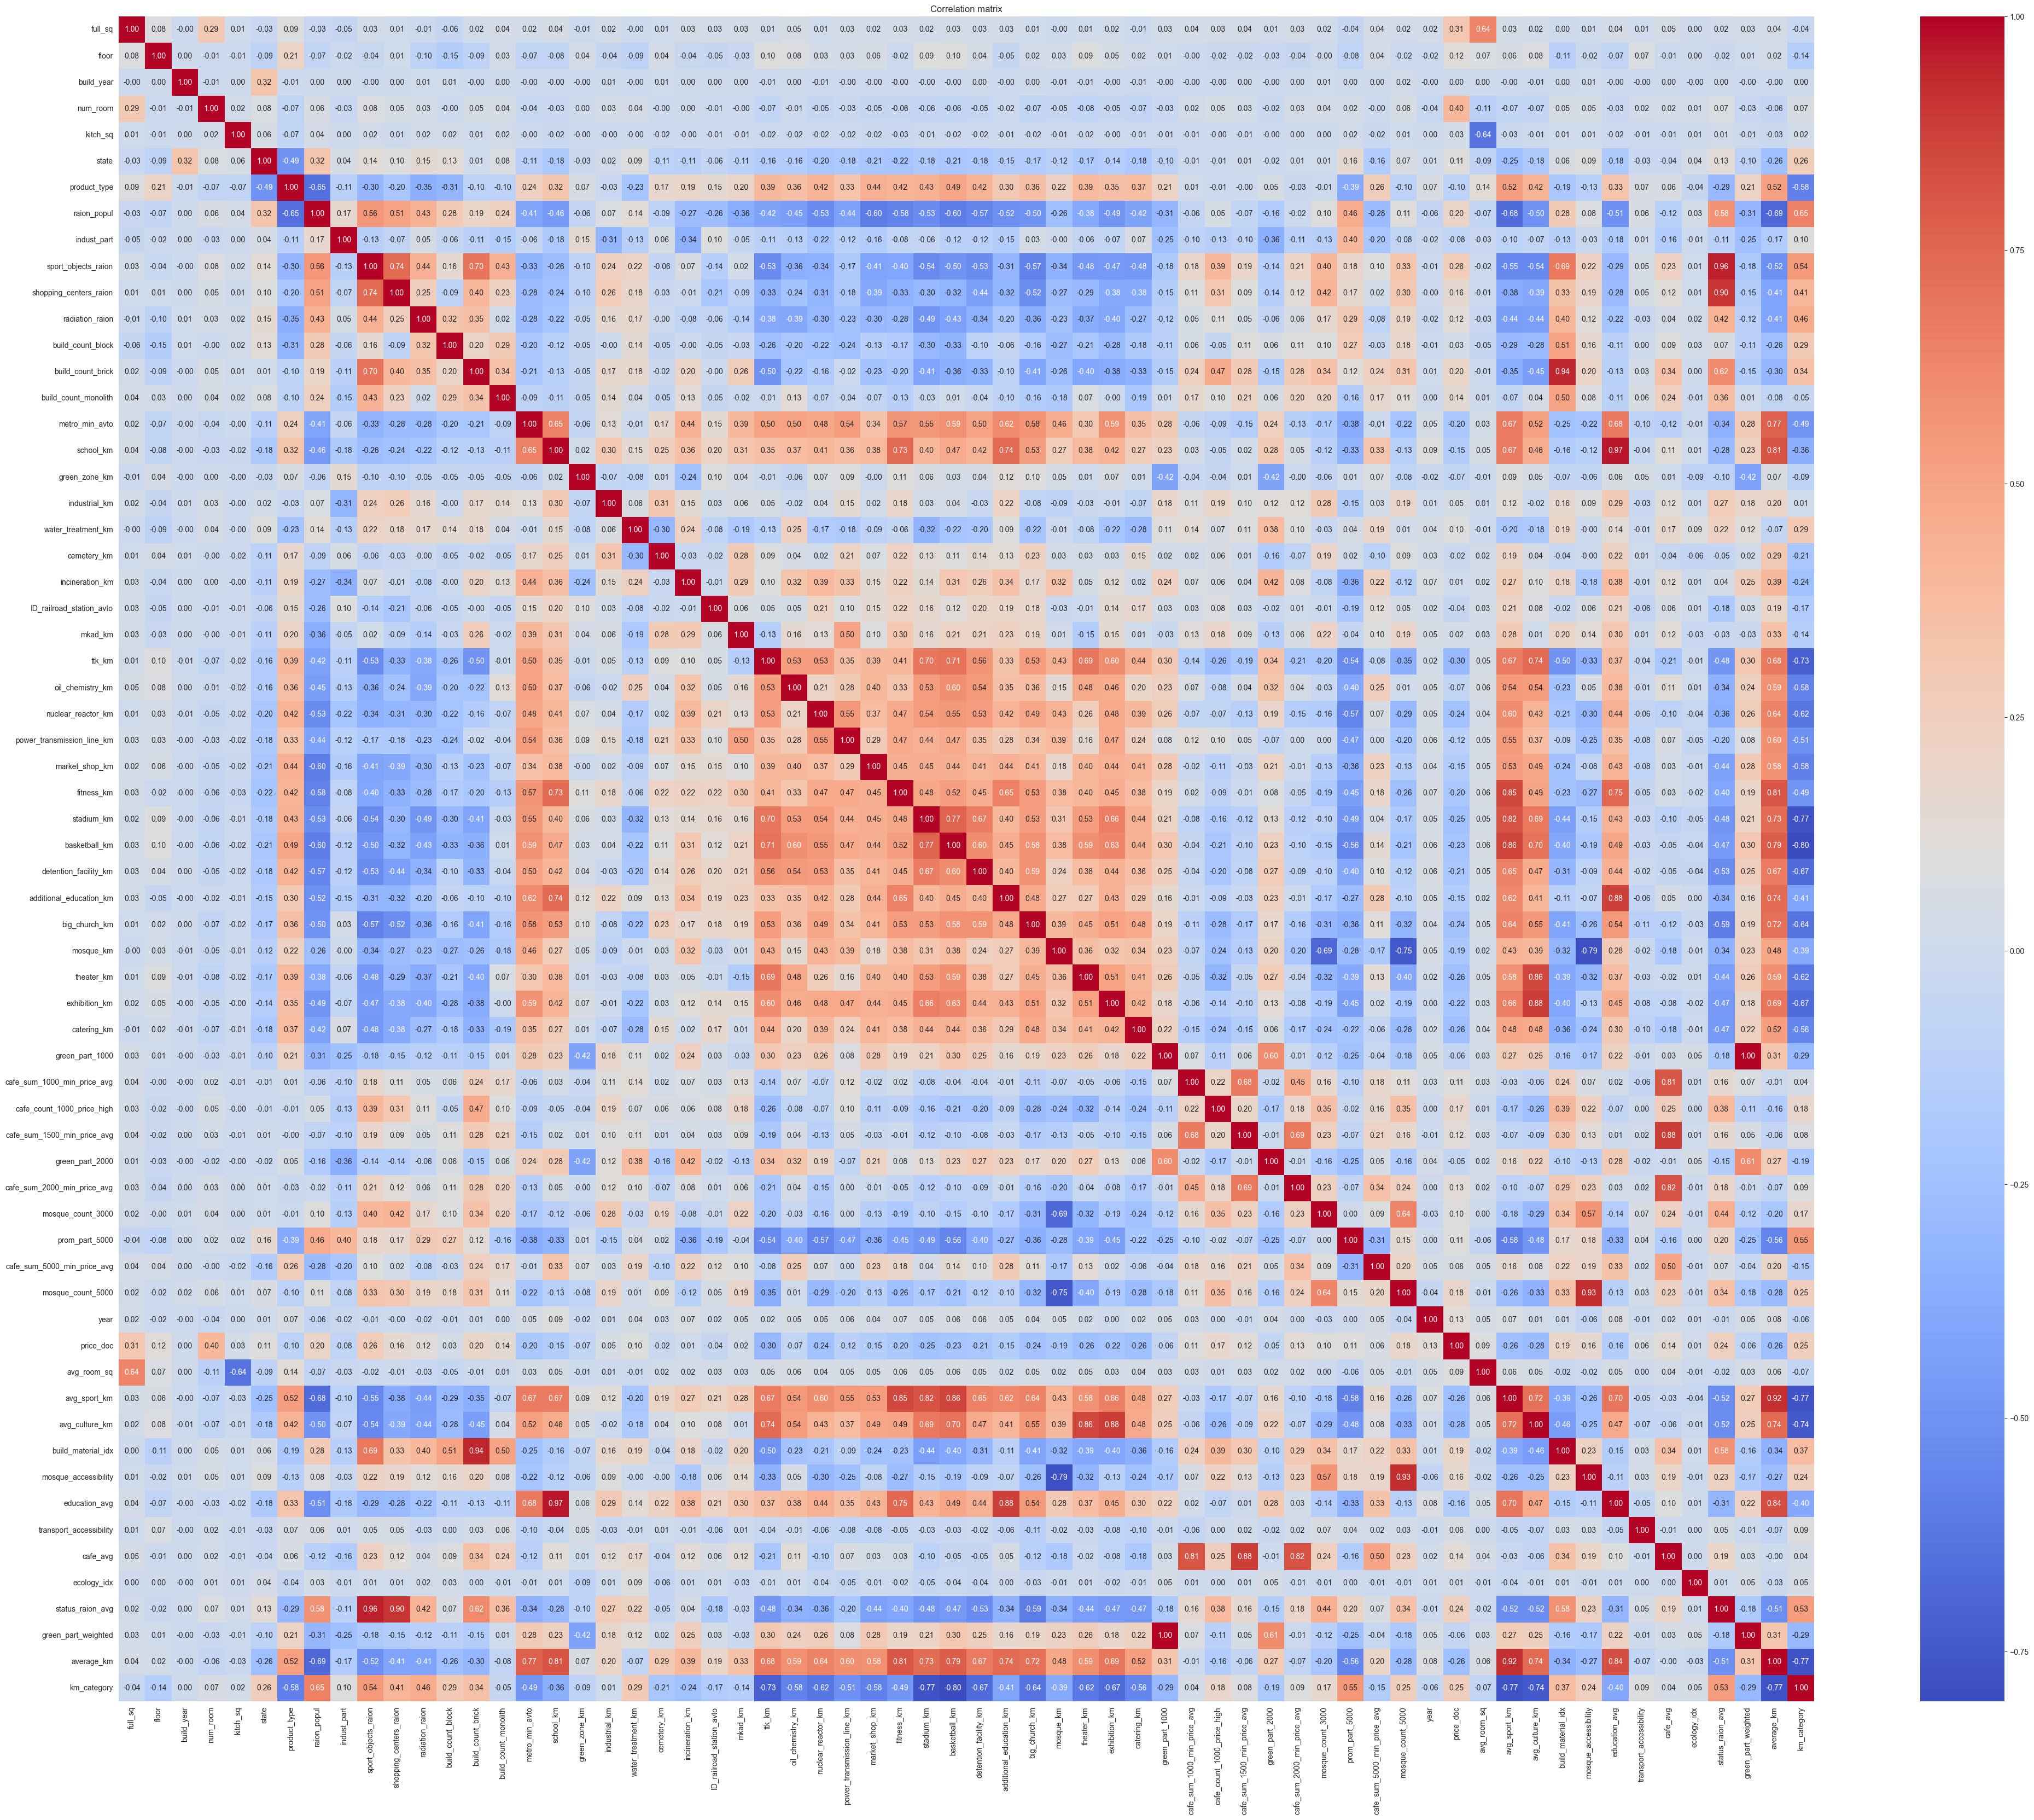

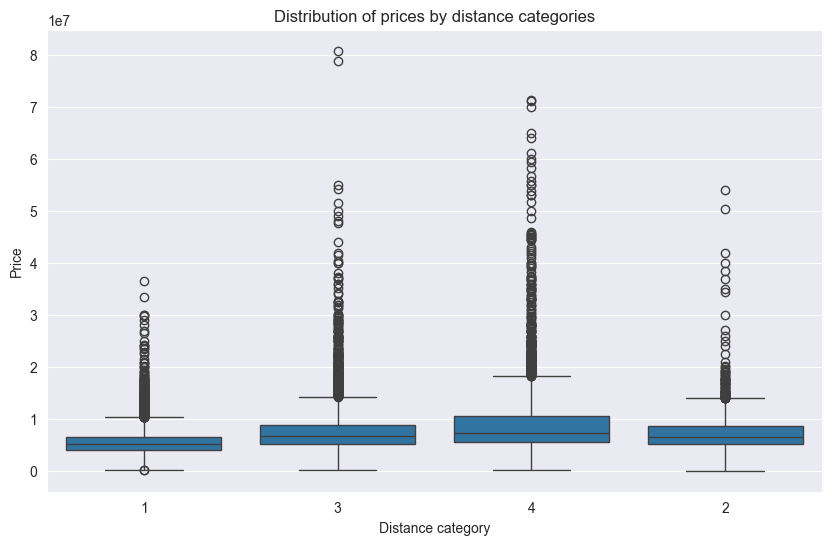

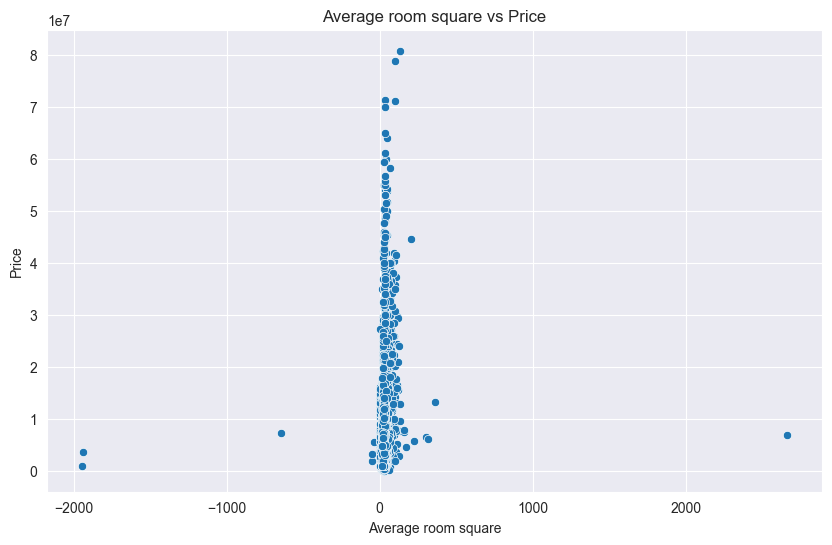

In [8]:
# Distribution of target variable (price_doc)
plt.figure(figsize=(10, 6))
sb.histplot(df['price_doc'], kde=True, bins=30)
plt.title('Real estate price distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Correlation matrix for numerical features
plt.figure(figsize=(50, 40))
corr_matrix = df.corr()
sb.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

# Distribution of prices by category (km_category)
plt.figure(figsize=(10, 6))
sb.boxplot(x='km_category', y='price_doc', data=df)
plt.title('Distribution of prices by distance categories')
plt.xlabel('Distance category')
plt.ylabel('Price')
plt.show()

# The influence of the average room area on the price
plt.figure(figsize=(10, 6))
sb.scatterplot(x='avg_room_sq', y='price_doc', data=df)
plt.title('Average room square vs Price')
plt.xlabel('Average room square')
plt.ylabel('Price')
plt.show()

## Model preparing

In [9]:
# Definition target and features
target = 'price_doc'
X = df.drop(target, axis=1)
y = df[target]

# Features and target preparing
X = X.dropna()
y = y.loc[X.index]

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0000000000001, random_state=52)

# Creating and training the Catboost models

In [11]:
# Сreating and fitting base Catboost regression model
model = CatBoostRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model evaluating
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean absolute error (MAE): {mae:.2f}")
print(f"Mean squared error (MSE): {mse:.2f}")
print(f"Root of root mean square error (RMSE): {rmse:.2f}")
print(f"Determination coefficient (R^2): {r2:.2f}")

Learning rate set to 0.066301
0:	learn: 4553252.5964779	total: 4.55ms	remaining: 4.54s
1:	learn: 4408378.5098411	total: 8.04ms	remaining: 4.01s
2:	learn: 4278097.8459406	total: 11.4ms	remaining: 3.79s
3:	learn: 4152808.1675614	total: 14.8ms	remaining: 3.68s
4:	learn: 4040128.8855723	total: 18.1ms	remaining: 3.59s
5:	learn: 3932817.3601313	total: 21.8ms	remaining: 3.61s
6:	learn: 3839792.1089528	total: 25.2ms	remaining: 3.57s
7:	learn: 3752924.6190503	total: 28.8ms	remaining: 3.57s
8:	learn: 3673637.3196257	total: 32.3ms	remaining: 3.55s
9:	learn: 3594806.2188596	total: 35.5ms	remaining: 3.52s
10:	learn: 3527847.6412929	total: 38.9ms	remaining: 3.49s
11:	learn: 3467604.0962562	total: 41.9ms	remaining: 3.45s
12:	learn: 3406103.1506596	total: 45.4ms	remaining: 3.44s
13:	learn: 3349001.0543211	total: 48.8ms	remaining: 3.44s
14:	learn: 3300384.1192712	total: 51.9ms	remaining: 3.41s
15:	learn: 3255617.6530807	total: 55.2ms	remaining: 3.4s
16:	learn: 3210720.7497667	total: 58.6ms	remaining: 3

/opt/homebrew/anaconda3/envs/SHIFT/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


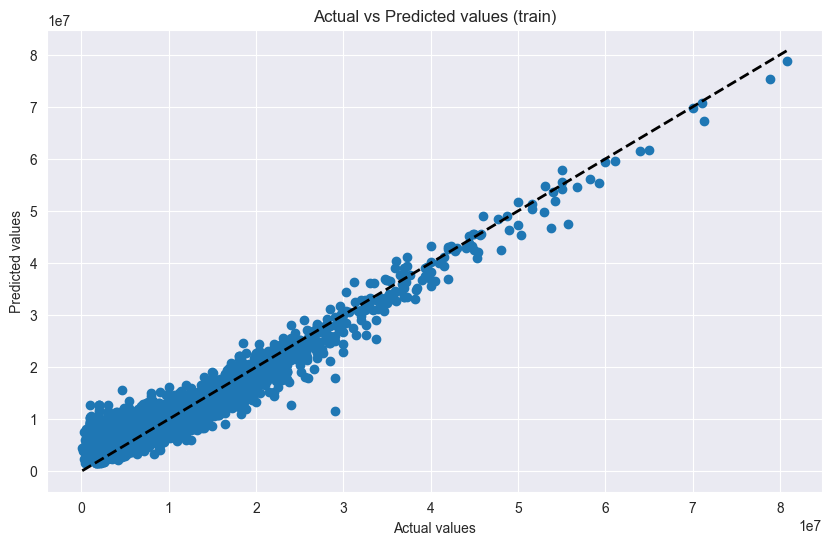

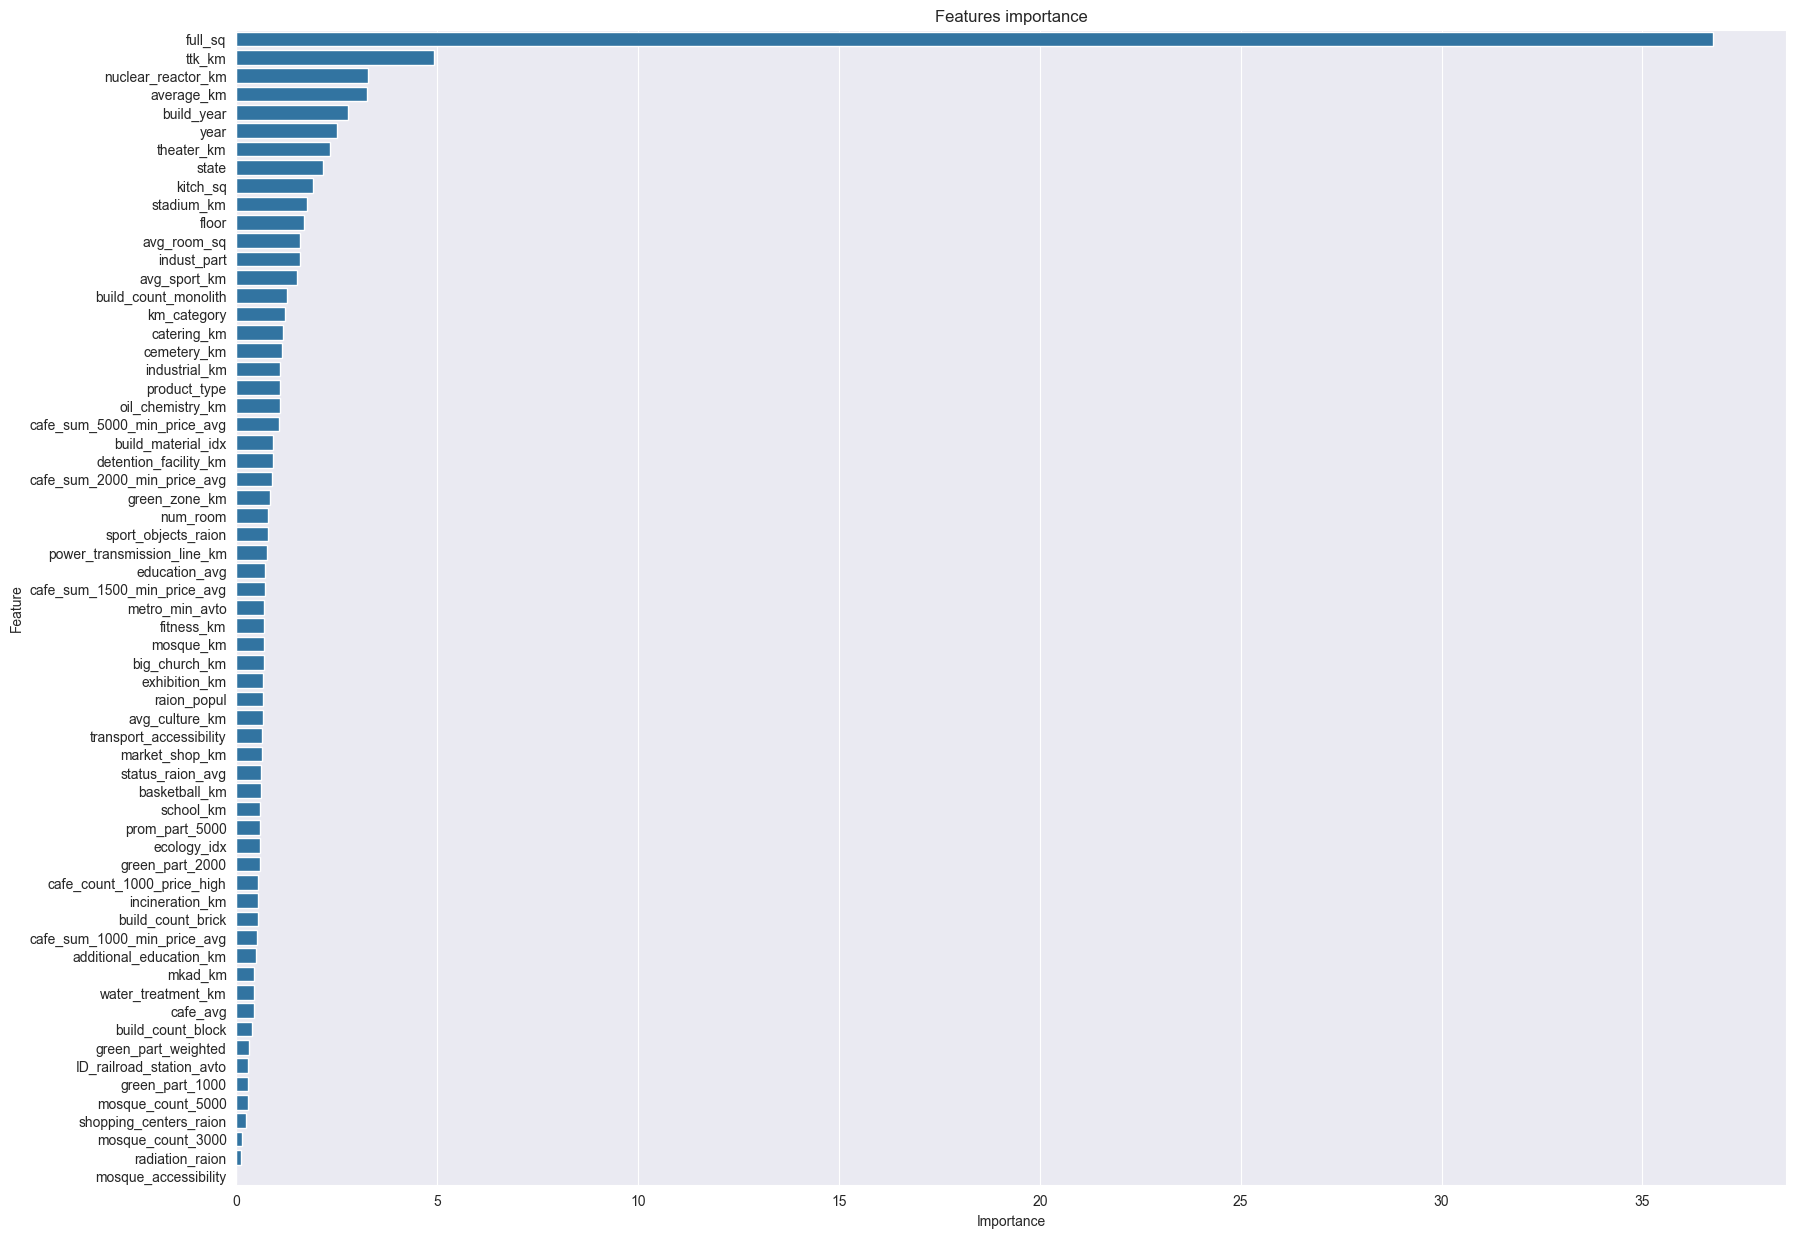

In [12]:
# Actual vs Predicted values (train)
plt.figure(figsize=(10, 6))
plt.scatter(y_train, model.predict(X_train))
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Actual vs Predicted values (train)')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

# Importance features evaluating
feature_importances = model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 15))
sb.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Features importance')
plt.show()

# Working with model parameters

In [13]:
# Definition of model parameters
params = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'loss_function': ['RMSE']
}

# Definition of categorical features
cat_features = [X_train.columns.get_loc(col) for col in categorical_columns if col in X_train.columns]

# Creating Catboost model with categorical features
model = CatBoostRegressor(cat_features=cat_features)

# Using GridSearchCV to search best parameters
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Choosing and fitting the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
0:	learn: 4793767.9651583	total: 76.3ms	remaining: 38.1s
1:	learn: 4771564.3188971	total: 94.7ms	remaining: 23.6s
2:	learn: 4749145.5890005	total: 108ms	remaining: 17.9s
3:	learn: 4726524.3435857	total: 117ms	remaining: 14.5s
4:	learn: 4704827.3021892	total: 129ms	remaining: 12.7s
5:	learn: 4683422.5992893	total: 154ms	remaining: 12.7s
6:	learn: 4662374.3595426	total: 173ms	remaining: 12.2s
7:	learn: 4642006.7731852	total: 186ms	remaining: 11.4s
8:	learn: 4621193.9715558	total: 201ms	remaining: 11s
9:	learn: 4600893.8270635	total: 219ms	remaining: 10.7s
10:	learn: 4581473.6732885	total: 228ms	remaining: 10.1s
11:	learn: 4562142.8454151	total: 240ms	remaining: 9.74s
12:	learn: 4542663.9818845	total: 250ms	remaining: 9.38s
13:	learn: 4523041.9077385	total: 262ms	remaining: 9.1s
14:	learn: 4503755.0127503	total: 272ms	remaining: 8.79s
15:	learn: 4485213.7194343	total: 292ms	remaining: 8.82s
16:	learn: 4466714.4179742	total: 302m

# Checking the results on the test sample and calculate the metrics

In [14]:
# Fitting and predictions
y_pred = best_model.predict(X_test)

# Model evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean absolute error (MAE): {mae:.2f}")
print(f"Mean squared error (MSE): {mse:.2f}")
print(f"Root of root mean square error (RMSE): {rmse:.2f}")
print(f"Determination coefficient (R^2): {r2:.2f}")

Mean absolute error (MAE): 851347.55
Mean squared error (MSE): 724792644272.48
Root of root mean square error (RMSE): 851347.55
Determination coefficient (R^2): nan


/opt/homebrew/anaconda3/envs/SHIFT/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# Loading and processing test data

In [20]:
# Loading test data
test_df = pd.read_csv('test.csv', index_col=0)

# Creating new features for test data
test_df['avg_room_sq'] = (test_df['full_sq'] - test_df['kitch_sq']) / test_df['num_room']
test_df['avg_sport_km'] = test_df[['fitness_km', 'stadium_km', 'basketball_km']].mean(axis=1)
test_df['avg_culture_km'] = test_df[['theater_km', 'exhibition_km']].mean(axis=1)
test_df['build_material_idx'] = test_df[['build_count_block', 'build_count_brick', 'build_count_monolith']].mean(axis=1)
test_df['mosque_accessibility'] = (test_df[['mosque_count_3000', 'mosque_count_5000']].sum(axis=1) > 0).astype(int)
test_df['education_avg'] = test_df[['school_km', 'additional_education_km']].mean(axis=1)
test_df['transport_accessibility'] = (test_df['mkad_km'] + test_df['ttk_km']) / test_df['metro_min_avto']
test_df['cafe_avg'] = test_df[['cafe_sum_1000_min_price_avg', 'cafe_sum_1500_min_price_avg', 'cafe_sum_2000_min_price_avg', 'cafe_sum_5000_min_price_avg']].mean(axis=1)
test_df['ecology_idx'] = test_df['water_treatment_km'] / test_df['green_zone_km']
test_df['status_raion_avg'] = test_df[['sport_objects_raion', 'shopping_centers_raion', 'radiation_raion']].mean(axis=1)
test_df['green_part_weighted'] = test_df['green_part_2000'] * 0.2 + test_df['green_part_1000'] * 0.8
test_df

full_sq  floor  build_year  num_room  kitch_sq  state  product_type  \
0          39    4.0      1979.0       2.0       6.0    2.0             0   
1          28    1.0      1979.0       2.0       6.0    2.0             0   
2          38    3.0      1979.0       2.0       6.0    2.0             0   
3          38    3.0      1979.0       2.0       6.0    2.0             1   
4          53   10.0      2009.0       2.0       9.0    2.0             0   
...       ...    ...         ...       ...       ...    ...           ...   
9137       54    4.0      1975.0       2.0       9.0    3.0             0   
9138       30    2.0      1979.0       2.0       6.0    2.0             0   
9139       41    2.0      1961.0       2.0       6.0    2.0             0   
9140       78    5.0      1979.0       3.0       0.0    2.0             1   
9141       39   10.0      2000.0       1.0      10.0    3.0             0   

      raion_popul  indust_part  sport_objects_raion  ...  avg_sport_km  \
0       12.419041     0.090799                   16  ...      1.137700   
1       12.018097     0.133215                   13  ...      0.437035   
2       11.262899     0.195781                    2  ...      1.167298   
3        9.164611     0.072158                    1  ...      1.964414   
4       11.482043     0.122090                    7  ...      0.007377   
...           ...          ...                  ...  ...           ...   
9137    10.187839     0.000000                   20  ...      0.596756   
9138    12.024569     0.111627                   18  ...      0.363095   
9139    11.457000     0.038693                    7  ...      0.346738   
9140    11.274795     0.437885                    3  ...      1.477158   
9141    11.299621     0.050756                   10  ...      0.807691   

      avg_culture_km  build_material_idx  mosque_accessibility  education_avg  \
0           1.655326            8.000000                     0       0.205145   
1           1.442608           90.333333                     0       0.706532   
2          -0.720840           60.000000                     1       0.547012   
3           2.371632           38.333333                     1       3.257763   
4           1.451723          109.333333                     1       0.477590   
...              ...                 ...                   ...            ...   
9137        0.245506           55.666667                     1       0.853661   
9138        1.469632          127.333333                     0       0.199242   
9139        0.776697           72.333333                     0       0.214135   
9140        2.284245           31.666667                     0       0.452454   
9141        1.917683           30.000000                     0       0.429114   

      transport_accessibility  cafe_avg  ecology_idx  status_raion_avg  \
0                    1.620076  6.402013     6.483707         10.333333   
1                    2.428162  6.596977     2.559832          6.000000   
2                    2.190421  6.498302     3.230061          1.333333   
3                    0.514394  6.481225    48.780490          0.333333   
4                    2.710936  6.234671     7.652059          2.333333   
...                       ...       ...          ...               ...   
9137                 2.720549  6.727938     8.138336          8.333333   
9138                 0.515209  6.651470    14.438308          7.333333   
9139                 2.146012  6.377501     8.608703          4.333333   
9140                 0.841646  6.545157     6.021672          3.000000   
9141                 0.736520  6.449380     6.132815          3.666667   

      green_part_weighted  
0               22.767346  
1                5.058768  
2                1.967281  
3               26.218771  
4                3.533806  
...                   ...  
9137            20.776836  
9138             7.115954  
9139            16.247471  
9140            12.482980  
9141             5.980

# Making post-processing of test data

In [26]:
# Average distance across all labels
test_df['average_km'] = df[km_columns].mean(axis=1)

# Categorizing distances
test_df['km_category'] = pd.cut(test_df['average_km'], bins=bins, labels=labels)
test_df['km_category'] = test_df['km_category'].map({'Very close': 4, 'Close': 3, 'Middle': 2, 'Far': 1}).astype(str)

# Converting categorical features to strings
for col in categorical_columns:
    if col in test_df.columns:
        test_df[col] = test_df[col].astype(str)

# Preparing test data for prediction
X_test_final = test_df.drop(columns=[target], errors='ignore')

# Ensuring all categorical features are strings in the test data
for col in cat_features:
    X_test_final.iloc[:, col] = X_test_final.iloc[:, col].astype(str)

In [27]:
# Creating Pool for test data
test_pool = Pool(data=X_test_final, cat_features=cat_features)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9142 entries, 0 to 9141
Data columns (total 63 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   full_sq                      9142 non-null   int64  
 1   floor                        9142 non-null   float64
 2   build_year                   9142 non-null   float64
 3   num_room                     9142 non-null   float64
 4   kitch_sq                     9142 non-null   float64
 5   state                        9142 non-null   object 
 6   product_type                 9142 non-null   object 
 7   raion_popul                  9142 non-null   float64
 8   indust_part                  9142 non-null   float64
 9   sport_objects_raion          9142 non-null   int64  
 10  shopping_centers_raion       9142 non-null   int64  
 11  radiation_raion              9142 non-null   object 
 12  build_count_block            9142 non-null   float64
 13  build_count_brick      

# Predictions on a test data set and uploading them to csv

In [28]:
# Predictions on a sample of test data
test_predictions = best_model.predict(test_pool)

# Creating submission.csv file
submission = pd.DataFrame({'price_doc': test_predictions})
submission.index.name = ''

# Saving to CSV
submission.to_csv('submission.csv', index=True)